In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

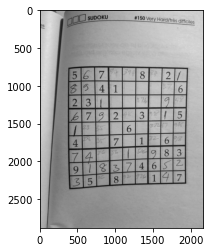

In [78]:
img = cv.imread("sudoku2.jpg", 0)
plt.imshow(img, cmap="gray")

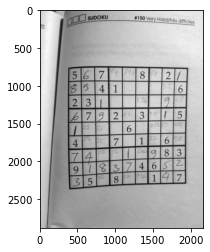

In [79]:
blurred_img = cv.GaussianBlur(img.copy(), (11,11), 0)
plt.imshow(blurred_img, cmap='gray')

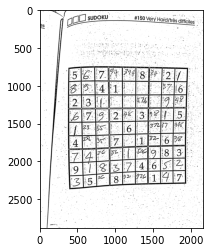

In [80]:
th = cv.adaptiveThreshold(blurred_img, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 11, 2)
plt.imshow(th, cmap='gray')

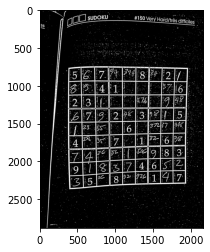

In [81]:
neg = cv.bitwise_not(th)
plt.imshow(neg, cmap='gray')

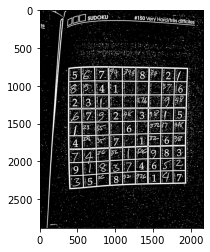

In [82]:
# dilate to fill in cracks
kernel = np.array([[0., 1., 0.], [1., 1., 1.],[0., 1., 0.]], np.uint8)
dilated = cv.dilate(neg, kernel)
plt.imshow(dilated, cmap='gray')

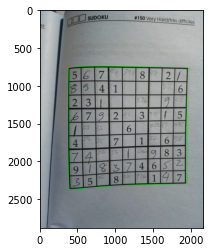

In [84]:
# find the contours from the thresholded image
color_img = cv.imread("sudoku2.jpg")
contours, hierarchy = cv.findContours(dilated, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv.contourArea, reverse=True)
drawn_contours = cv.drawContours(color_img, contours, 0, (0,255,0), 3)
plt.imshow(drawn_contours)

In [33]:
max_area = -1
max_pt = (-1,-1)

for y, row in enumerate(dilated):
    for x, cell in enumerate(row):
        if (cell >= 128):
            area = cv.floodFill(dilated, (x,y), (0, 0, 64))
            
            if (area > max_area):
                max_pt = (x,y)
                max_area = area
                
print(max_pt)
print(max_area)

TypeError: floodFill() missing required argument 'newVal' (pos 4)